In [1]:
import pandas as pd
import numpy as np
import sys
import pickle
import glob
import os
import matplotlib.pyplot as plt

In [2]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV,ShuffleSplit

In [3]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [4]:
def GradientBooster(param_grid, n_jobs, X_train, y_train):
    estimator = GradientBoostingRegressor()
    cv = ShuffleSplit(n_splits=10, train_size=0.8, test_size=0.2, random_state=0)
    classifier = GridSearchCV(estimator=estimator, cv=cv, param_grid=param_grid, n_jobs=n_jobs)
    classifier.fit(X_train, y_train)
    print('best estimator found by grid search: {}'.format(classifier.best_estimator_))
    return cv, classifier.best_estimator_


In [5]:
merged_df = pd.read_pickle('/Users/darylwilding-mcbride/Downloads/experiments/190719_Hela_Ecoli/training-sets/merged_df.pkl')
merged_df.head()

,file_idx,sequence,charge,run_mz,run_scan,run_rt,theoretical_mz,experiment_scan,experiment_rt,experiment_intensity,delta_mz,delta_scan,delta_rt
0,0,AAAAAAAAAPAAAATAPTTAATTAATAAQ,2,1184.608424,74.065131,601.582008,1184.1049,73.911301,602.012681,108754.444444,-0.503524,-0.153831,0.430673
1,0,AAAAAAAAVPSAGPAGPAPTSAAGR,2,1016.532311,156.625361,486.692475,1016.0286,160.291329,489.973155,58456.622222,-0.503711,3.665967,3.280680
2,0,AAAAAWEEPSSGNGTAR,2,823.382064,535.310000,367.240000,822.8783,533.861853,371.271659,277023.690476,-0.503764,-1.448147,4.031659
3,0,AAAAPVTGPLADDPIQETITFDDFAK,3,892.112987,468.100000,997.180000,891.7775,465.668232,997.391366,150202.950000,-0.335487,-2.431768,0.211366
4,0,AAAEDVNVTFEDQQK,2,832.891998,485.630000,471.790000,832.3878,487.082550,475.841292,116982.693430,-0.504198,1.452550,4.051292


In [6]:
file_idx = 0

m/z delta estimation model (version 1)

m/z delta estimation model (version 2)

In [11]:
merged_df.columns

Index(['file_idx', 'sequence', 'charge', 'run_mz', 'run_scan', 'run_rt',
       'theoretical_mz', 'experiment_scan', 'experiment_rt',
       'experiment_intensity', 'delta_mz', 'delta_scan', 'delta_rt'],
      dtype='object')

In [12]:
X = merged_df[merged_df.file_idx == file_idx][['theoretical_mz','experiment_rt','experiment_scan','experiment_intensity']].values
y = merged_df[merged_df.file_idx == file_idx]['delta_mz'].values

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [16]:
best_estimator = GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=6,
                          max_features=1.0, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=5, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [17]:
# use the best parameters to train the model
best_estimator.fit(X_train, y_train)
print("R-squared for training set (best model found): {}".format(best_estimator.score(X_train, y_train)))

R-squared for training set (best model found): 0.7439596713086486


In [18]:
# use the trained model to predict the m/z for the test set
y_test_predicted = best_estimator.predict(X_test)

In [19]:
y_test_predicted

array([-0.502102  , -0.50170179, -0.4959516 , ..., -0.49957134,
       -0.49575341, -0.50360659])

In [20]:
y_test

array([-0.50374641, -0.50370816, -0.5030744 , ..., -0.50284049,
       -0.50353374, -0.50367441])

In [21]:
y_test_delta = np.abs(y_test_predicted) - np.abs(y_test)

In [22]:
np.std(y_test_delta)

0.04953483416944708

In [23]:
abs(y_test_delta).max()

0.2896619090166162

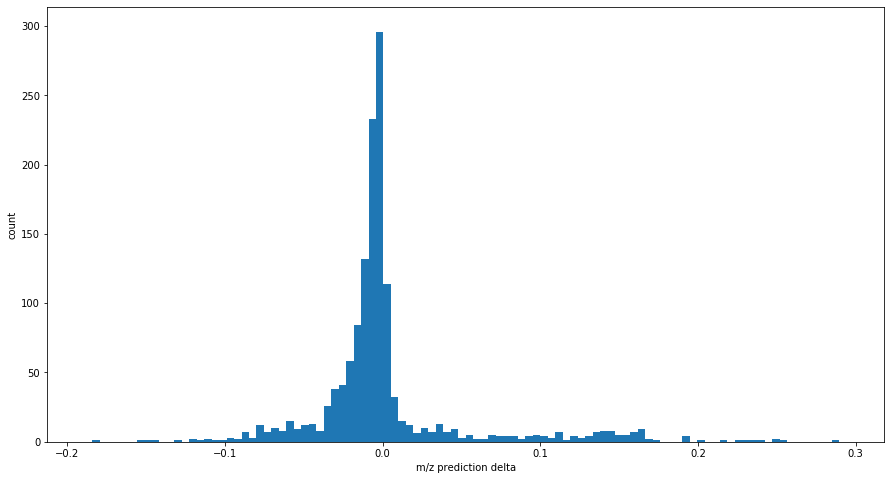

In [24]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('')

bins = 100
hist, bins, _ = plt.hist(y_test_delta, bins=bins, label='m/z delta')
plt.xlabel('m/z prediction delta')
plt.ylabel('count')

plt.show()

scan estimation model (version 1)

In [25]:
merged_df.columns

Index(['file_idx', 'sequence', 'charge', 'run_mz', 'run_scan', 'run_rt',
       'theoretical_mz', 'experiment_scan', 'experiment_rt',
       'experiment_intensity', 'delta_mz', 'delta_scan', 'delta_rt'],
      dtype='object')

In [26]:
X = merged_df[merged_df.file_idx == file_idx][['theoretical_mz','experiment_rt','experiment_scan','experiment_intensity']].values
y = merged_df[merged_df.file_idx == file_idx]['run_scan'].values

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [28]:
# search for the best model in the specified hyperparameter space
param_grid = {'n_estimators':[100], 'learning_rate': [0.1, 0.05, 0.02, 0.01], 'max_depth':[20, 10, 6, 4], 'min_samples_leaf':[3, 5, 9, 17], 'max_features':[1.0, 0.3, 0.1] }
n_jobs = 4
cv, best_estimator = GradientBooster(param_grid, n_jobs, X_train, y_train)

best estimator found by grid search: GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=4,
                          max_features=1.0, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=17, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)


In [30]:
best_estimator = GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=4,
                          max_features=1.0, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=17, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [31]:
# use the best parameters to train the model
best_estimator.fit(X_train, y_train)
print("R-squared for training set (best model found): {}".format(best_estimator.score(X_train, y_train)))

R-squared for training set (best model found): 0.9990251307606186


In [32]:
# use the trained model to predict the scan for the test set
y_test_predicted = best_estimator.predict(X_test)

In [33]:
y_test_predicted

array([350.03718707, 260.30771911, 820.48825882, ...,  86.94984863,
       724.54631704, 105.82739351])

In [34]:
y_test

array([351.30126543, 261.11637   , 823.38      , ...,  86.07864884,
       725.85      , 101.129455  ])

In [35]:
y_test_delta = np.abs(y_test_predicted) - np.abs(y_test)

In [36]:
np.std(y_test_delta)

8.176662014758335

In [37]:
abs(y_test_delta).max()

128.1148374797976

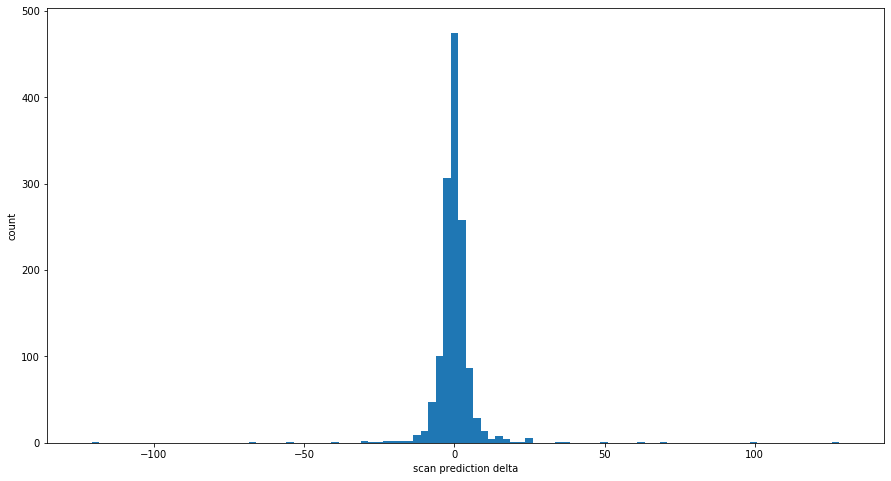

In [38]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('')

bins = 100
hist, bins, _ = plt.hist(y_test_delta, bins=bins, label='m/z delta')
plt.xlabel('scan prediction delta')
plt.ylabel('count')

plt.show()

RT estimation model (version 1)

In [39]:
merged_df.columns

Index(['file_idx', 'sequence', 'charge', 'run_mz', 'run_scan', 'run_rt',
       'theoretical_mz', 'experiment_scan', 'experiment_rt',
       'experiment_intensity', 'delta_mz', 'delta_scan', 'delta_rt'],
      dtype='object')

In [40]:
X = merged_df[merged_df.file_idx == file_idx][['theoretical_mz','experiment_rt','experiment_scan','experiment_intensity']].values
y = merged_df[merged_df.file_idx == file_idx]['run_rt'].values

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [43]:
best_estimator = GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=4,
                          max_features=1.0, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=17, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [44]:
# use the best parameters to train the model
best_estimator.fit(X_train, y_train)
print("R-squared for training set (best model found): {}".format(best_estimator.score(X_train, y_train)))

R-squared for training set (best model found): 0.9993863088433734


In [45]:
# use the trained model to predict the scan for the test set
y_test_predicted = best_estimator.predict(X_test)

In [46]:
y_test_predicted

array([ 920.233159  ,  834.18458849, 1054.31954107, ...,  872.29950106,
        907.60290162,  597.52104815])

In [47]:
y_test

array([ 922.30918493,  832.68778387, 1058.02      , ...,  877.02784058,
        905.24      ,  597.65      ])

In [48]:
y_test_delta = np.abs(y_test_predicted) - np.abs(y_test)

In [49]:
np.std(y_test_delta)

5.445375323559336

In [50]:
abs(y_test_delta).max()

142.71028445808952

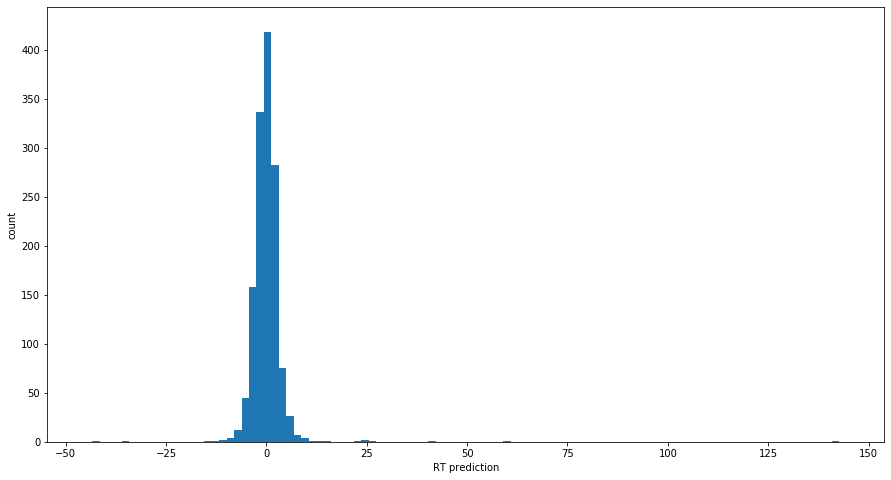

In [51]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('')

bins = 100
hist, bins, _ = plt.hist(y_test_delta, bins=bins, label='m/z delta')
plt.xlabel('RT prediction')
plt.ylabel('count')

plt.show()

For an identification that was missing in this run, estimate its coordinates and have a look there.